<a href="https://colab.research.google.com/github/gitHubAndyLee2020/Satellite_Image_Classification_Project/blob/main/Satellite_Image_Classification_Project_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Building CNN from Scratch

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving satellite_image_dataset.zip to satellite_image_dataset.zip
User uploaded file "satellite_image_dataset.zip" with length 22836290 bytes


In [ ]:
!unzip satellite_image_dataset.zip

In [32]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


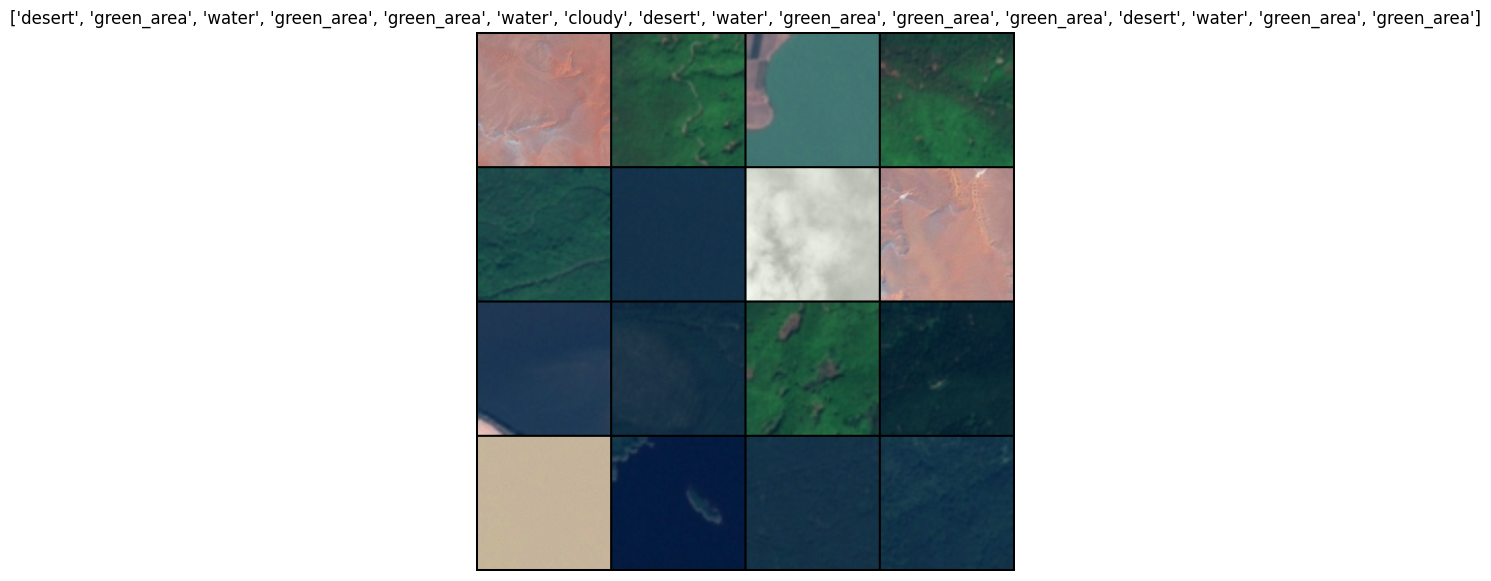

In [33]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, random_split
import torch

# Assuming the dataset is stored under 'content/data'
dataset_path = '/content/data'

# Image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
])

# Create a PyTorch Dataset from the image data
image_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split the dataset into train and test sets
train_size = int(0.8 * len(image_dataset))
test_size = len(image_dataset) - train_size
train_dataset, test_dataset = random_split(image_dataset, [train_size, test_size])

# Create PyTorch DataLoaders from the datasets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to display images and labels
def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(15, 7))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# Get some random training images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Get class names
class_names = image_dataset.classes

# Show images and labels
grid_size = min(16, batch_size)
imshow(utils.make_grid(images[:grid_size], nrow=4, padding=2, normalize=True),
       [class_names[x] for x in labels[:grid_size]])

In [34]:
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([32, 3, 128, 128])
Shape of y: torch.Size([32]) torch.int64


In [45]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):  # Assuming 4 classes corresponding to the 4 subfolders
        super(SimpleCNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.act3 = nn.ReLU()

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.act3(x)

        x = self.fc2(x)
        return x

In [46]:
# Initialize the model, loss, and optimizer
num_classes = 4  # Update this based on the number of classes in your dataset
model = SimpleCNN(num_classes=num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print the model architecture
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (act3): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


In [47]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [48]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [67]:
# Define a mapping from numerical labels to actual categories
label_map = {0: "cloudy", 1: "desert", 2: "green_area", 3: "water"}

# Function to display images and labels
def imshow(img, title):
    npimg = img.cpu().numpy()
    plt.figure(figsize=(15, 7))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    title_text = "\n".join([", ".join(title[i:i+4]) for i in range(0, len(title), 4)])
    plt.title(title_text)
    plt.show()

def display_predictions(dataloader, model, device):
    model.eval()
    images_so_far = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X).argmax(1)

            # Accumulate a batch of 16 images and labels
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            images_so_far += X.shape[0]

            if images_so_far >= 16:
                break

    # Get the class names based on label_map
    class_names = [f"A: {label_map[actual]}, P: {label_map[pred]}"
                   for actual, pred in zip(all_labels[:16], all_preds[:16])]

    # Make a grid from batch
    out = utils.make_grid(X.cpu()[:16], nrow=4, padding=2, normalize=True)

    imshow(out, class_names)

In [49]:
import os
import torch

def save_model(model, path):
    # Create the 'model' folder if it doesn't exist
    if not os.path.exists('model'):
        os.makedirs('model')

    # Save the model weights
    torch.save(model.state_dict(), os.path.join('model', path))

In [ ]:
epochs = 100
history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test_loss, correct = test(test_loader, model, loss_fn)
    history.append((test_loss, correct))
    save_model(model, f'model_epochs_{t}.pth')
print("Done!")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Separate test_loss and correct into two different lists
test_loss = [item[0] for item in history]
correct = [item[1] for item in history]

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(correct, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Finding the maximum correct value and its index
max_correct_value = np.max(correct)
max_correct_index = np.argmax(correct)

print(f"The maximum accuracy is {max_correct_value}% at epoch {max_correct_index}.")

In [ ]:
print(f"model/model_epochs_{max_correct_index}.pth")

In [59]:
loaded_model = SimpleCNN().to(device)
loaded_model.load_state_dict(torch.load(f"model/model_epochs_{max_correct_index}.pth"))

<All keys matched successfully>

In [60]:
test_loss, correct = test(test_loader, loaded_model, loss_fn)

Test Error: 
 Accuracy: 96.8%, Avg loss: 0.126458 



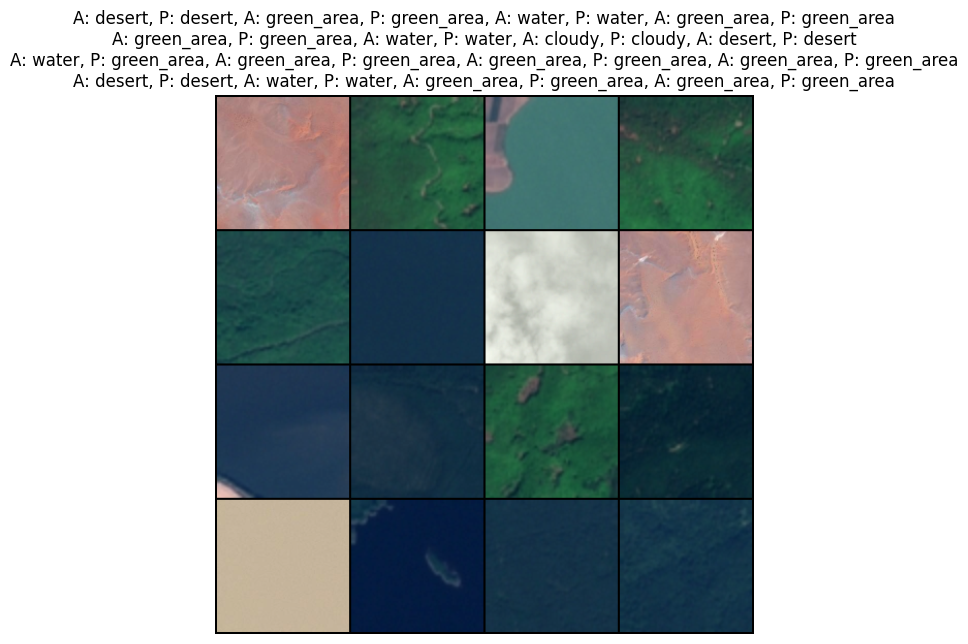

In [68]:
display_predictions(test_loader, model, device)